## __ECON 8210 Homework 2__

__Prepared by:__ Mahmut Eymen Akin

University of Pennsylvania

### Recursive Formulation of the Model

#### 1. Bellman Equation

The household's problem is expressed as:

$$
V(k, z) = \max_{c, l, k'} \left\{ \log(c) - \frac{l^2}{2} + \beta \mathbb{E}_{z'} \left[ V(k', z') \right] \right\}
$$

##### Subject to:

1. **Budget Constraint**:
   $$
   c + k' - 0.9k = w(k, z) l + r(k, z) k
   $$

---

#### 2. Firm's Problem

The firm hires labor $l$ and rents capital $k$ to maximize profits. Its problem is:

$$
\max_{l, k} \left\{ e^z k^{0.33} l^{0.67} - w l - r k \right\}
$$


##### First-Order Conditions for the Firm

1. **Labor Demand**:
   $$
   \frac{\partial \pi}{\partial l} = 0.67 e^z k^{0.33} l^{-0.33} - w = 0 \implies w = 0.67 e^z k^{0.33} l^{-0.33}
   $$

2. **Capital Demand**:
   $$
   \frac{\partial \pi}{\partial k} = 0.33 e^z k^{-0.67} l^{0.67} - r = 0 \implies r = 0.33 e^z k^{-0.67} l^{0.67}
   $$

The firm takes $w$ and $r$ as given (competitive markets) and uses the production function:

$$
y = e^z k^{0.33} l^{0.67}
$$

---

#### 3. Recursive First-Order Conditions for the Household

From the household's Bellman equation, the FOCs are:

1. **Consumption ($c$)**:
   $$
   \frac{\partial V}{\partial c}: \quad \frac{1}{c} = \lambda
   $$

2. **Labor ($l$)**:
   $$
   \frac{\partial V}{\partial l}: \quad -l + \lambda w = 0 \implies w = l c
   $$

3. **Capital Next Period ($k'$)**:
   $$
   \frac{\partial V}{\partial k'}: \quad \lambda = \beta \mathbb{E}_{z'} \left[ \frac{\partial V}{\partial k}(k', z') \right]
   $$

Substituting $\lambda = \frac{1}{c}$ and using the Envelope condition, the Euler equation becomes:

$$
\frac{1}{c} = \beta \mathbb{E}_{z'} \left[ \frac{1}{c'(k', z')} \left( r(k', z') + 0.9 \right) \right]
$$

---

#### 4. Market Clearing Conditions

##### a. Labor Market:
The labor supplied by the household equals the labor demanded by the firm:
$$
l = l(k, z)
$$

##### b. Capital Market:
The capital supplied by the household equals the capital demanded by the firm:
$$
k = k
$$

##### c. Goods Market:
The total output produced by the firm is used for consumption and investment:
$$
c + k' - 0.9k = e^z k^{0.33} l^{0.67}
$$

---

#### 5. Law of Motion of Technology

   $$
   z' = 0.95z + 0.007\epsilon, \quad \epsilon \sim N(0, 1)
   $$

Let $\delta = 0.1$. Combining, we get the following equations characterizing the policy functions:
$$
\left( \frac{1}{c} \right) e^{z} k^{\alpha} (1 - \alpha) l^{ - \alpha} = l \tag{1}
$$

$$
\frac{1}{c} = \beta E_{z^\prime} \left[ \frac{1}{c^\prime} \left( e^{z^\prime} \alpha (k^\prime)^{\alpha - 1} (l^\prime)^{1 - \alpha} + 1 - \delta \right) \right] \tag{2}
$$
$$
c + k^\prime = e^{z} k^{\alpha} l^{1 - \alpha} + (1 - \delta) k \tag{3}
$$

### The Steady State

Suppose that under the steady state $z_{ss} = 0$. Then, the steady state policies will be given by:

$$
\left( \frac{1}{c_{ss}} \right) k_{ss}^{\alpha} (1 - \alpha) l_{ss}^{ - \alpha} = l_{ss} \tag{$1_{ss}$}
$$

$$
\frac{1}{\beta} =\left( \alpha k_{ss}^{\alpha - 1} l_{ss}^{1 - \alpha} + 1 - \delta \right) \tag{$2_{ss}$}
$$
$$
c_{ss} + \delta k_{ss} =  k_{ss}^{\alpha} l_{ss}^{1 - \alpha} \tag{$3_{ss}$}
$$

# 1. Chebyshev

In [1]:
#########################################
# 0.0 Housekeeping
#########################################
α = 0.33  # capital share
β = 0.97  # discount factor
δ = 0.1   # depreciation rate
ρ = 0.95  # AR(1) persistence
σ = 0.007 # AR(1) standard deviation

#import Pkg; Pkg.add("FastGaussQuadrature")
using Roots, LinearAlgebra, Plots, Distributions, FastGaussQuadrature
using JuMP, Ipopt
using NLsolve

#########################################
# 0.1 Computing the Steady-State Values
#########################################

# Function to compute steady state given k
function steady_state()
    # From (2_ss): β(αk^(α-1)l^(1-α) + 1-δ) = 1
    # From (1_ss): (1/c)k^α(1-α)l^(-α) = l
    # From (3_ss): c + δk = k^αl^(1-α)
    
    function ss_equations(x)
        k, l, c = x
        
        eq1 = β*(α*k^(α-1)*l^(1-α) + 1-δ) - 1
        eq2 = (1/c)*k^α*(1-α)*l^(-α) - l
        eq3 = c + δ*k - k^α*l^(1-α)
        
        return [eq1; eq2; eq3]
    end
    
    # Initial guess
    x0 = [1.0; 0.3; 0.5]
    
    # Solve system of equations
    result = nlsolve(ss_equations, x0)
    
    return result.zero
end

##########################################
# 0.2 Tauchen method for tech process
#########################################

function tauchen(ρ, σ, N)
    m = 3  # Number of standard deviations
    z = range(-m*σ/sqrt(1-ρ^2), m*σ/sqrt(1-ρ^2), length=N)
    step = z[2] - z[1]
    
    # Transition probabilities
    Π = zeros(N, N)
    for i in 1:N
        for j in 1:N
            if j == 1
                Π[i,j] = cdf(Normal(), (z[j] + step/2 - ρ*z[i])/σ)
            elseif j == N
                Π[i,j] = 1 - cdf(Normal(), (z[j] - step/2 - ρ*z[i])/σ)
            else
                Π[i,j] = cdf(Normal(), (z[j] + step/2 - ρ*z[i])/σ) - 
                         cdf(Normal(), (z[j] - step/2 - ρ*z[i])/σ)
            end
        end
    end
    
    return z, Π
end

# Create 3-point approximation
N_z = 3
z_grid, Π = tauchen(ρ, σ, N_z)

k_ss, l_ss, c_ss = steady_state()

##########################################
# 1.1 Setting Up Chebyshev Nodes
##########################################
k_min = 0.5 * k_ss
k_max = 1.5 * k_ss

# Chebyshev polynomial functions
function cheb_polynomial(x::Real, n::Integer)
    if n == 0
        return 1.0
    elseif n == 1
        return x
    else
        return 2x * cheb_polynomial(x, n-1) - cheb_polynomial(x, n-2)
    end
end

# When x is an array, we want to broadcast the scalar version
function cheb_polynomial(x::AbstractArray, n::Integer)
    return cheb_polynomial.(x, n)
end


# Transform [-1,1] to [a,b]
function transform_domain(x, a, b)
    return (b-a)/2 .* x .+ (b+a)/2
end


# Create Chebyshev nodes
function cheb_nodes(n, a, b)
    x = -cos.((2 .* collect(1:n) .- 1) .* π ./ (2n))
    return transform_domain(x, a, b)
end

# Number of Chebyshev polynomials
n_cheb = 6
k_nodes = cheb_nodes(n_cheb, k_min, k_max)

function cheb_basis_2d(k, z, n_k, n_z)
    # Map state variables to [-1,1]
    k_mapped = 2 * (k - k_min)/(k_max - k_min) - 1
    z_mapped = 2 * (z - minimum(z_grid))/(maximum(z_grid) - minimum(z_grid)) - 1
    
    # Create basis matrices for each dimension
    basis_k = zeros(n_k)
    basis_z = zeros(n_z)
    
    # Fill in basis evaluations
    for i in 1:n_k
        basis_k[i] = cheb_polynomial(k_mapped, i-1)
    end
    for j in 1:n_z
        basis_z[j] = cheb_polynomial(z_mapped, j-1)
    end
    
    # Return flattened tensor product
    return vec(basis_k * basis_z')
end



#############################################
# 1.2 Recover Policy given Chebyshev Coeffs
#############################################
# Modified capital policy function using 2D Chebyshev
function k_prime_policy(k, z, coeffs)
    basis = cheb_basis_2d(k, z, n_cheb, 3)  # 3 is for z dimension
    return dot(coeffs, basis)
end

# Recover labor given k, k', and z
function get_labor(k, k_next, z)
    # Create optimization model
    model = Model(Ipopt.Optimizer)
    set_silent(model)  # Suppress solver output
    
    # Define variable for labor with reasonable bounds
    @variable(model, 0.01 <= l <= 5.0, start=l_ss)
    
    # Production and consumption
    y = exp(z) * k^α * l^(1-α)
    c = y + (1-δ)*k - k_next
    
    # Labor FOC: (1/c)*e^z*k^α*(1-α)*l^(-α) = l
    @NLobjective(model, Min, ((1/c)*exp(z)*k^α*(1-α)*l^(-α) - l)^2)
    
    # Solve the model
    optimize!(model)
    
    return value(l)
end

# Function to get consumption given k, k', l, and z
function get_consumption(k, k_next, l, z)
    return exp(z) * k^α * l^(1-α) + (1-δ)*k - k_next
end

#############################################
# 1.2 Define Residual Function from Euler Eqn
#############################################

function euler_residual(coeffs, k, z_idx)
    z = z_grid[z_idx]
    
    # Get k' using the 2D approximation
    k_next = k_prime_policy(k, z, coeffs)
    
    # Get current labor and consumption
    l = get_labor(k, k_next, z)
    c = get_consumption(k, k_next, l, z)
    
    # Initialize RHS of Euler equation
    rhs = 0.0
    
    # Compute expectation over future z
    for (z_next_idx, z_next) in enumerate(z_grid)
        k_next_next = k_prime_policy(k_next, z_next, coeffs)
        
        l_next = get_labor(k_next, k_next_next, z_next)
        c_next = get_consumption(k_next, k_next_next, l_next, z_next)
        
        mpk_next = α * exp(z_next) * k_next^(α-1) * l_next^(1-α)
        
        rhs += Π[z_idx, z_next_idx] * (1/c_next) * (mpk_next + 1-δ)
    end
    
    return 1/c - β*rhs
end


# System of equations for all collocation points
function system_residuals(coeffs)
    residuals = zeros(n_cheb * N_z)
    idx = 1
    
    for z_idx in 1:N_z
        for k in k_nodes
            residuals[idx] = euler_residual(coeffs, k, z_idx)
            idx += 1
        end
    end
    
    return residuals
end


#############################################
# 1.3 Solve for Coefficients
#############################################


# Initial guess for coefficients
n_coeffs = n_cheb * N_z  # Total number of coefficients
initial_coeffs = zeros(n_coeffs)
# Set constant term
initial_coeffs[1] = k_ss
# Set linear terms
initial_coeffs[2] = 0.95  # for capital
initial_coeffs[n_cheb + 1] = 0.1  # for productivity

# Solve for coefficients

solution = nlsolve(system_residuals, initial_coeffs)
coeffs = solution.zero

# Create functions to evaluate policies
function compute_policies(k, z_idx)
    k_next = k_prime_policy(k, z_grid[z_idx], coeffs)
    l = get_labor(k, k_next, z_grid[z_idx])
    c = get_consumption(k, k_next, l, z_grid[z_idx])
    return k_next, l, c
end




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



compute_policies (generic function with 1 method)

In [2]:
i_ss = δ * k_ss
y_ss = k_ss^α * l_ss^(1-α)
k_ss, l_ss, c_ss, y_ss, i_ss


(3.761205944166286, 0.9464557586062026, 1.11614168272168, 1.492262277136954, 0.3761205944166286)

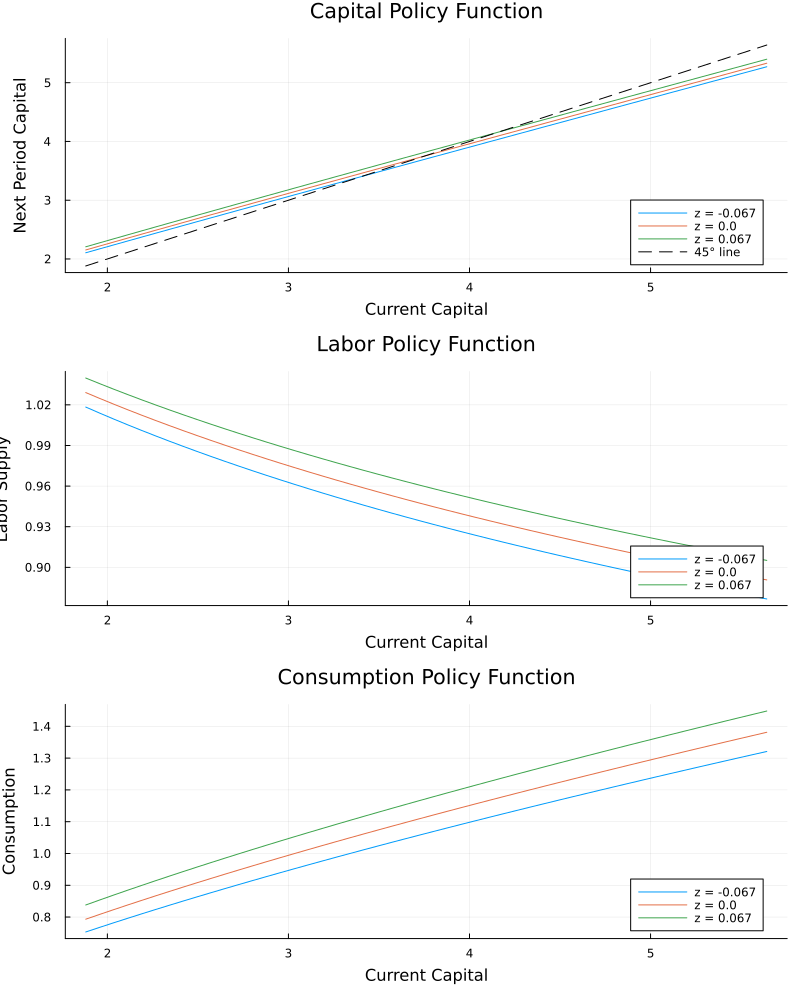

In [3]:
#############################################
# 1.4 Plot the Policies
#############################################
# Create finer grids for smooth plotting
k_plot = range(k_min, k_max, length=50)
z_plot = range(minimum(z_grid), maximum(z_grid), length=50)

# Compute policy values over the grid
k_policies = zeros(length(k_plot), length(z_plot))
l_policies = zeros(length(k_plot), length(z_plot))
c_policies = zeros(length(k_plot), length(z_plot))

for (i, k) in enumerate(k_plot)
    for (j, z) in enumerate(z_plot)
        # Capital policy
        k_next = k_prime_policy(k, z, solution.zero)
        
        # Labor and consumption policies
        l = get_labor(k, k_next, z)
        c = get_consumption(k, k_next, l, z)
        
        k_policies[i,j] = k_next
        l_policies[i,j] = l
        c_policies[i,j] = c
    end
end

# Create 2D plots showing policies for different z values
p1 = plot(title="Capital Policy Function", 
          xlabel="Current Capital", 
          ylabel="Next Period Capital",
          legend=:bottomright)
for (i, z) in enumerate(z_grid)
    z_idx = argmin(abs.(z_plot .- z))
    plot!(k_plot, k_policies[:,z_idx], 
          label="z = $(round(z, digits=3))")
end
plot!(k_plot, k_plot, label="45° line", linestyle=:dash, color=:black)

p2 = plot(title="Labor Policy Function",
          xlabel="Current Capital",
          ylabel="Labor Supply",
          legend=:bottomright)
for (i, z) in enumerate(z_grid)
    z_idx = argmin(abs.(z_plot .- z))
    plot!(k_plot, l_policies[:,z_idx],
          label="z = $(round(z, digits=3))")
end

p3 = plot(title="Consumption Policy Function",
          xlabel="Current Capital",
          ylabel="Consumption",
          legend=:bottomright)
for (i, z) in enumerate(z_grid)
    z_idx = argmin(abs.(z_plot .- z))
    plot!(k_plot, c_policies[:,z_idx],
          label="z = $(round(z, digits=3))")
end

# Combine 2D plots
plot(p1, p2, p3, layout=(3,1), size=(800,1000))

savefig("q1fin.png")



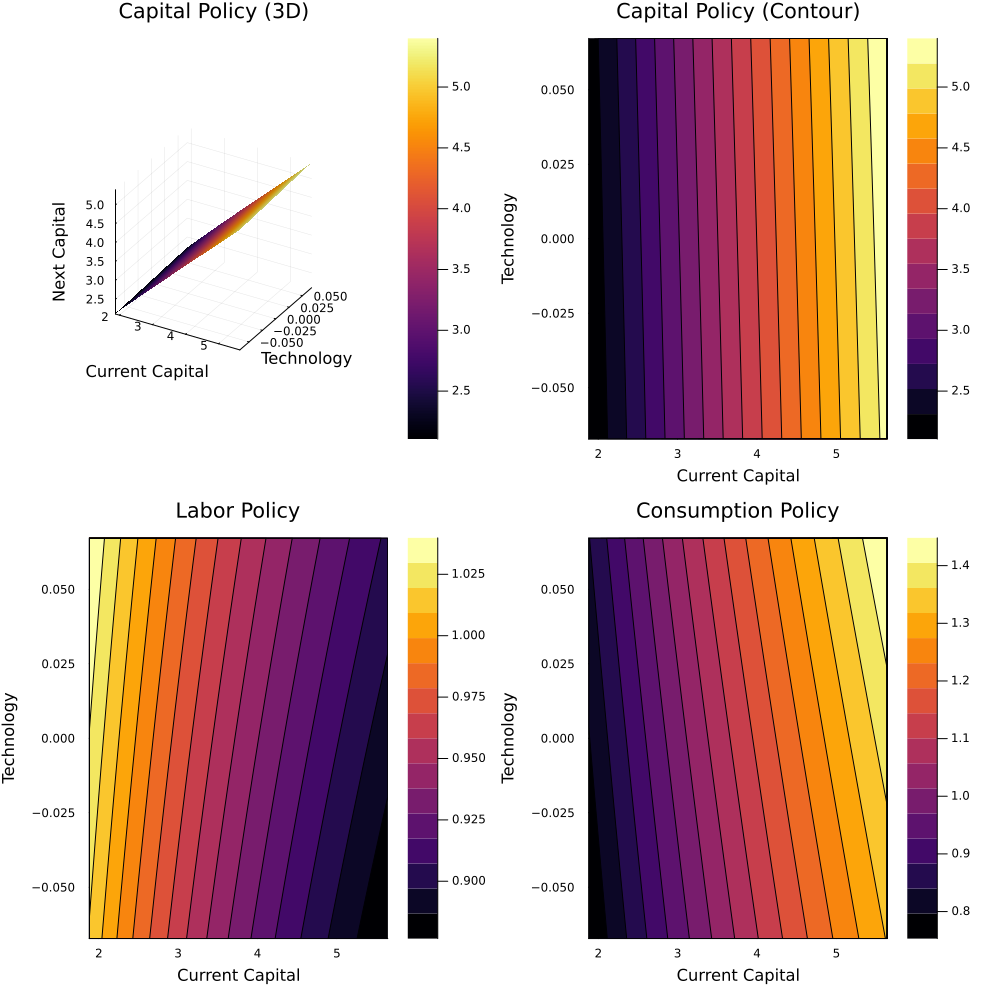

In [4]:
# Create contour plots and a 3D plot alongside our previous visualizations
# Create four subplots: 3D surface, contour, and 2D slices for capital policy
p4 = surface(k_plot, z_plot, k_policies',
            title="Capital Policy (3D)",
            xlabel="Current Capital",
            ylabel="Technology",
            zlabel="Next Capital",
            camera=(30,30))

p5 = contour(k_plot, z_plot, k_policies',
             title="Capital Policy (Contour)",
             xlabel="Current Capital",
             ylabel="Technology",
             fill=true)

# Add contour plots for labor and consumption
p6 = contour(k_plot, z_plot, l_policies',
             title="Labor Policy",
             xlabel="Current Capital",
             ylabel="Technology",
             fill=true)

p7 = contour(k_plot, z_plot, c_policies',
             title="Consumption Policy",
             xlabel="Current Capital",
             ylabel="Technology",
             fill=true)

# Combine all plots
plot(p4, p5, p6, p7, layout=(2,2), size=(1000,1000))

# 2. Finite Elements

In [5]:
##########################################
# 1. Parameters and Setup
##########################################

using FastGaussQuadrature, NLsolve, LinearAlgebra


##########################################
# 2. Finite Element Grid Setup
##########################################

const N_k_fe = 8  # Number of finite elements
const k_grid_fe = range(k_min, k_max, length=N_k_fe+1)  # N_k_fe+1 nodes for N_k_fe elements
const N_coeffs_fe = (N_k_fe + 1) * N_z  # Total number of coefficients


##########################################
# 3. Linear Basis Functions
##########################################

"""
Evaluate the linear basis function centered at node idx for capital value k.
These are "hat functions" that equal 1 at their center node and 0 at adjacent nodes.
"""
function linear_basis_fe(k, idx)
    N = length(k_grid_fe)
    
    # Early return if k is outside the global domain
    if k < k_grid_fe[1] || k > k_grid_fe[end]
        return 0.0
    end
    
    if idx == 1  # Leftmost basis function
        if k > k_grid_fe[2]
            return 0.0
        end
        return (k_grid_fe[2] - k) / (k_grid_fe[2] - k_grid_fe[1])
        
    elseif idx == N  # Rightmost basis function
        if k < k_grid_fe[N-1]
            return 0.0
        end
        return (k - k_grid_fe[N-1]) / (k_grid_fe[N] - k_grid_fe[N-1])
        
    else  # Interior basis functions
        if k < k_grid_fe[idx-1] || k > k_grid_fe[idx+1]
            return 0.0
        end
        if k <= k_grid_fe[idx]
            return (k - k_grid_fe[idx-1]) / (k_grid_fe[idx] - k_grid_fe[idx-1])
        else
            return (k_grid_fe[idx+1] - k) / (k_grid_fe[idx+1] - k_grid_fe[idx])
        end
    end
end

##########################################
# 4. Policy Function Approximation
##########################################

"""
Compute next period's capital using finite element approximation.
Uses the coefficients and basis functions to construct the policy function.
"""
function k_prime_policy_fe(k, z_idx, coeffs_fe)
    N_k = length(k_grid_fe)
    
    # Get coefficients for current z state
    idx_start = (z_idx - 1) * N_k + 1
    idx_end = z_idx * N_k
    coeffs_z = coeffs_fe[idx_start:idx_end]
    
    # Compute weighted sum of basis functions
    k_next = 0.0
    for idx in 1:N_k
        k_next += coeffs_z[idx] * linear_basis_fe(k, idx)
    end
    
    return k_next
end

##########################################
# 5. Galerkin Method Implementation
##########################################

"""
Compute the Galerkin-weighted residual of the Euler equation.
Integrates the Euler residual against each basis function using Gaussian quadrature.
"""
function euler_residual_fe(coeffs_fe, k_idx, z_idx)
    N_k = length(k_grid_fe)
    
    # Setup Gaussian quadrature
    n_quad = 5  # Number of quadrature points
    nodes, weights = gausslegendre(n_quad)
    
    # Define integration domain (support of basis function)
    if k_idx == 1
        elements = [(k_grid_fe[1], k_grid_fe[2])]
    elseif k_idx == N_k
        elements = [(k_grid_fe[N_k-1], k_grid_fe[N_k])]
    else
        elements = [(k_grid_fe[k_idx-1], k_grid_fe[k_idx]),
                   (k_grid_fe[k_idx], k_grid_fe[k_idx+1])]
    end
    
    # Initialize weighted residual
    weighted_residual = 0.0
    
    # Integrate over relevant elements
    for (a, b) in elements
        # Transform quadrature points to element
        k_quad = @. (b-a)/2 * nodes + (b+a)/2
        w_quad = @. weights * (b-a)/2
        
        # Compute integral using quadrature
        for (k, w) in zip(k_quad, w_quad)
            # Evaluate basis function
            phi_i = linear_basis_fe(k, k_idx)
            
            # Skip if basis function is zero
            if phi_i == 0.0
                continue
            end
            
            # Current period calculations
            z = z_grid[z_idx]
            k_next = k_prime_policy_fe(k, z_idx, coeffs_fe)
            l = get_labor(k, k_next, z)
            c = get_consumption(k, k_next, l, z)
            
            # Future period calculations
            rhs = 0.0
            for (z_next_idx, z_next) in enumerate(z_grid)
                k_next_next = k_prime_policy_fe(k_next, z_next_idx, coeffs_fe)
                l_next = get_labor(k_next, k_next_next, z_next)
                c_next = get_consumption(k_next, k_next_next, l_next, z_next)
                mpk_next = α * exp(z_next) * k_next^(α - 1) * l_next^(1 - α)
                
                rhs += Π[z_idx, z_next_idx] * (1/c_next) * (mpk_next + 1 - δ)
            end
            
            # Euler equation residual
            residual = (1/c) - β * rhs
            weighted_residual += residual * phi_i * w
        end
    end
    
    return weighted_residual
end

##########################################
# 6. System of Equations
##########################################

"""
Construct the system of Galerkin equations.
Returns residuals for each node and productivity state.
"""
function system_residuals_fe(coeffs_fe)
    N_k = length(k_grid_fe)
    N_z = length(z_grid)
    residuals = zeros(N_k * N_z)
    
    for z_idx in 1:N_z
        for k_idx in 1:N_k
            idx = (z_idx - 1) * N_k + k_idx
            residuals[idx] = euler_residual_fe(coeffs_fe, k_idx, z_idx)
        end
    end
    
    return residuals
end

##########################################
# 7. Solve the System
##########################################

# Total number of coefficients
N_coeffs_fe = (N_k_fe + 1) * N_z

# Create initial guess (linear policy around steady state)
initial_coeffs_fe = zeros(N_coeffs_fe)
for z_idx in 1:N_z
    for k_idx in 1:(N_k_fe + 1)
        idx = (z_idx-1)*(N_k_fe + 1) + k_idx
        k = k_grid_fe[k_idx]
        initial_coeffs_fe[idx] = k_ss + 0.95*(k - k_ss)
    end
end

# Solve the nonlinear system
solution_fe = nlsolve(system_residuals_fe, initial_coeffs_fe)
coeffs_fe = solution_fe.zero

27-element Vector{Float64}:
 2.1056625988439754
 2.5111416655958734
 2.911472661573576
 3.3088285455543165
 3.703849627681513
 4.097331731414636
 4.489663820071521
 4.881107336129909
 5.271917835754391
 2.154835432592695
 ⋮
 2.207659779438845
 2.618941683047141
 3.024193714149562
 3.425368435727002
 3.8237237743649723
 4.219902661071227
 4.614527357840465
 5.007891835076135
 5.400328413557844

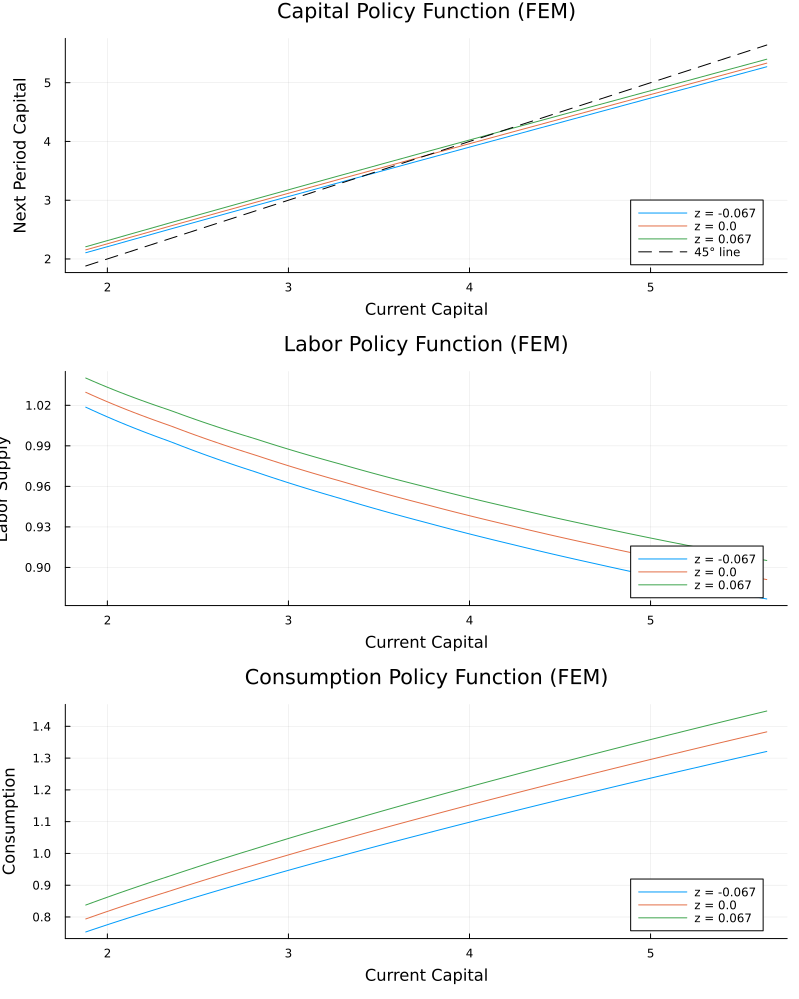

In [6]:
using Plots

# First, let's create a fine grid for smooth plotting
k_plot = range(k_min, k_max, length=100)
z_plot = z_grid  # We'll use our discrete z points

# Create arrays to store policy values
k_policies_fe = zeros(length(k_plot), length(z_plot))
l_policies_fe = zeros(length(k_plot), length(z_plot))
c_policies_fe = zeros(length(k_plot), length(z_plot))

# Compute policy values over the grid
for (i, k) in enumerate(k_plot)
    for (j, z) in enumerate(z_plot)
        # Capital policy
        k_next = k_prime_policy_fe(k, j, coeffs_fe)
        
        # Labor and consumption policies
        l = get_labor(k, k_next, z)
        c = get_consumption(k, k_next, l, z)
        
        k_policies_fe[i,j] = k_next
        l_policies_fe[i,j] = l
        c_policies_fe[i,j] = c
    end
end

# Create individual policy function plots
# Capital policy function
fe_p1 = plot(title="Capital Policy Function (FEM)", 
          xlabel="Current Capital", 
          ylabel="Next Period Capital",
          legend=:bottomright)

# Plot policy for each productivity level
for (j, z) in enumerate(z_plot)
    plot!(k_plot, k_policies_fe[:,j], 
          label="z = $(round(z, digits=3))")
end
# Add 45-degree line for reference
plot!(k_plot, k_plot, 
      label="45° line", 
      linestyle=:dash, 
      color=:black)

# Labor policy function
fe_p2 = plot(title="Labor Policy Function (FEM)",
          xlabel="Current Capital",
          ylabel="Labor Supply",
          legend=:bottomright)
for (j, z) in enumerate(z_plot)
    plot!(k_plot, l_policies_fe[:,j],
          label="z = $(round(z, digits=3))")
end

# Consumption policy function
fe_p3 = plot(title="Consumption Policy Function (FEM)",
          xlabel="Current Capital",
          ylabel="Consumption",
          legend=:bottomright)
for (j, z) in enumerate(z_plot)
    plot!(k_plot, c_policies_fe[:,j],
          label="z = $(round(z, digits=3))")
end

# Combine 2D plots in a vertical layout
plot(fe_p1, fe_p2, fe_p3, 
     layout=(3,1), 
     size=(800,1000))


savefig("q2fin.png")


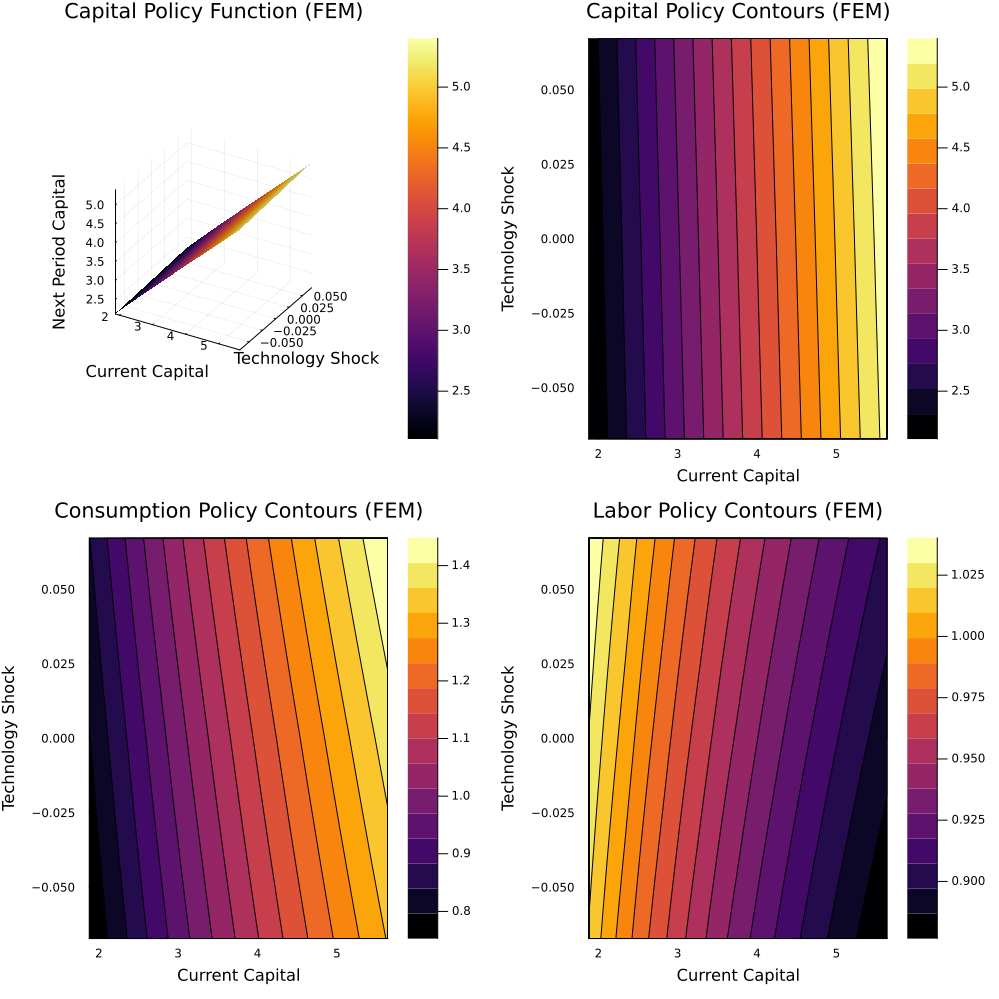

In [7]:
# Create 3D surface plot for capital policy
surface_plot = surface(k_plot, z_plot, k_policies_fe',
                      title="Capital Policy Function (FEM)",
                      xlabel="Current Capital",
                      ylabel="Technology Shock",
                      zlabel="Next Period Capital",
                      camera=(30,30))

# Create contour plot for capital policy
contour_plot_k = contour(k_plot, z_plot, k_policies_fe',
                      title="Capital Policy Contours (FEM)",
                      xlabel="Current Capital",
                      ylabel="Technology Shock",
                      fill=true)

# Create contour plot for labor policy
contour_plot_l = contour(k_plot, z_plot, l_policies_fe',
                      title="Labor Policy Contours (FEM)",
                      xlabel="Current Capital",
                      ylabel="Technology Shock",
                      fill=true)

# Create contour plot for capital policy
contour_plot_c = contour(k_plot, z_plot, c_policies_fe',
                      title="Consumption Policy Contours (FEM)",
                      xlabel="Current Capital",
                      ylabel="Technology Shock",
                      fill=true)

# Show both 3D and contour plots side by side
plot(surface_plot, contour_plot_k, contour_plot_c, contour_plot_l,
     layout=(2,2), 
     size=(1000,1000))